In [4]:
import landsat_prep as lp
import geograph as gg
import os

import matplotlib
import numpy as np
import torch
import torch.nn as nn

import argparse
import os
import pickle
import random
import shutil
import time

from PIL import Image

In [5]:
# Set variables
ISO = "MEX"
ADM_ID = "MEX-ADM2-1590546715-B7"
IC = "LANDSAT/LT05/C01/T1"
YEAR = "2010"
MONTH = "1"
GB_PATH = "./data/MEX/ipumns_shp.shp"

In [6]:
ADM_ID = "484001001"
lp.prep_landsat(GB_PATH, ISO, ADM_ID, "2010", "1", IC, v = False)

ADM_ID = "484001003"
lp.prep_landsat(GB_PATH, ISO, ADM_ID, "2010", "1", IC, v = False)

ADM_ID = "484014116"
lp.prep_landsat(GB_PATH, ISO, ADM_ID, "2010", "1", IC, v = False)

ADM_ID = "484014046"
lp.prep_landsat(GB_PATH, ISO, ADM_ID, "2010", "1", IC, v = False)

In [8]:
gl = gg.ImageGraphLoader("./data/", ISO, "/Users/heatherbaier/Desktop/geograph/test/migration_data.json", 1)#.data

In [9]:
gl.image_graphs[0].num_nodes

12

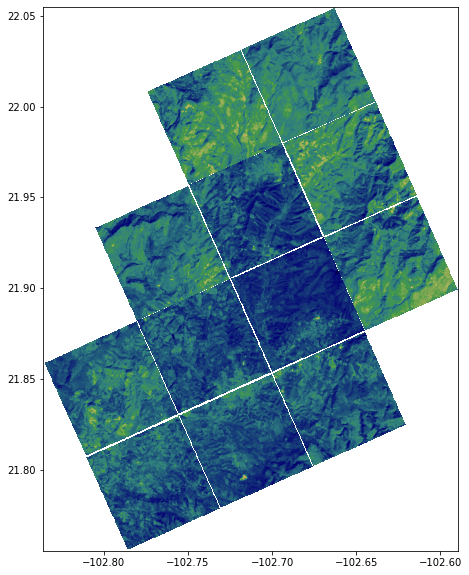

In [10]:
gl.image_graphs[0].show()

In [11]:
gl.image_graphs[0].x.shape

torch.Size([12, 3, 256, 256])

In [12]:
gl.data[0:2]

In [84]:
# GCN basic operation
class GraphConv(nn.Module):
    def __init__(self, input_dim, output_dim, bias=True):
        super(GraphConv, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = nn.Parameter(torch.rand(input_dim, output_dim))#.cuda())
        if bias:
            self.bias = nn.Parameter(torch.rand(output_dim))#.cuda())
        else:
            self.bias = None

    def forward(self, x, adj):
        y = torch.matmul(adj, x)
        y = torch.matmul(y, self.weight)
        if self.bias is not None:
            y = y + self.bias
        return y

# Generate Assignment Matrix
class GenAssign(nn.Module):
    def __init__(self, input_dim, num_clusters, bias=True):
        super(GenAssign, self).__init__()
        self.input_dim = input_dim
        self.num_clusters = num_clusters
        self.weight = nn.Parameter(torch.rand(input_dim, num_clusters))#.cuda())
        if bias:
            self.bias = nn.Parameter(torch.rand(num_clusters))#.cuda())
        else:
            self.bias = None
        # self.linear = torch.nn.Linear(input_dim, num_clusters)
        self.sm = torch.nn.Softmax(dim = 1)

    def forward(self, x, adj):
        y = torch.matmul(adj, x)
        y = torch.matmul(y, self.weight)
        if self.bias is not None:
            y = y + self.bias
        # y = self.linear(y)
        y = self.sm(y)
        _, i = torch.max(y, 1)
        return i


# Pool based on clusters
class PoolClusters(nn.Module):
    def __init__(self):
        super(PoolClusters, self).__init__()

    def forward(self, x, sl):
        cluster_ids = torch.unique(sl)
        for cluster in cluster_ids:
            indices = torch.nonzero(sl == cluster, as_tuple = True)[0]
            cluster_mean = torch.mean(torch.index_select(x, 0, indices), dim = 0).unsqueeze(0)
            try:
                out = torch.cat((out, cluster_mean))
            except Exception as e:
                out = cluster_mean
        return out


def make_edge_list(neighbors_dict):
    edge_list = []
    for k,v in neighbors_dict.items():
        [edge_list.append([k, cur_v]) for cur_v in v]
    return edge_list

def make_adj_matrix(edge_list, dim):
    adj_matrix = np.zeros((dim, dim))
    for edge in edge_list:
        adj_matrix[edge[0]][edge[1]] = 1
    for i in range(dim):
        adj_matrix[i][i] = 1

    return adj_matrix


def fix_sl(sl):
    cluster_ids = torch.unique(sl)
    ref = dict(zip([i.item() for i in cluster_ids], [i for i in range(len(cluster_ids))]))
    for i in cluster_ids:
        sl[sl == i.item()] = ref[i.item()]
    return sl


# GCN basic operation
class GenAdj(nn.Module):
    def __init__(self):
        super(GenAdj, self).__init__()

    def forward(self, adj, sl, neighbors_dict):

        sl = fix_sl(sl)

        adj_map, new_neighbors_dict = {}, {}
        cluster_ids = torch.unique(sl)

        # Create a dictionary where each key is a node and the value is the cluster it belongs to
        for cluster in cluster_ids:
            indices = torch.nonzero(sl == cluster, as_tuple = True)[0]
            for i in indices:
                if i not in adj_map.keys():
                    adj_map[i.item()] = cluster.item()

        # Create a new neighbors dictionary for each of the clusters
        for cluster in cluster_ids:
            indices = torch.nonzero(sl == cluster, as_tuple = True)[0]

            for i in indices:
                temp = []
                [temp.append(adj_map[i]) for i in neighbors_dict[i.item()] if i not in temp]
                temp = list(set(temp)) # TO-DO: HERE CREATE SOME SORT OF SECONDARY DICTIONARY OR SOMETHING THAT COUNTS HOW MANY EDGES TO CREATE WEIGHTED ADJ MATRIX

                new_neighbors_dict[cluster.item()] = temp

        edge_list = make_edge_list(new_neighbors_dict)
        adj_matrix = make_adj_matrix(edge_list, len(cluster_ids))

        return torch.tensor(adj_matrix, dtype = torch.float32), new_neighbors_dict


class diffPool(nn.Module):
    def __init__(self, input_dim, output_dim, num_clusters, bias=True):
        super(diffPool, self).__init__()

        self.gc = GraphConv(input_dim = input_dim, output_dim = output_dim)
        self.bn = torch.nn.BatchNorm1d(output_dim)
        self.gen_assign = GenAssign(input_dim = output_dim, num_clusters = num_clusters)
        self.pool = PoolClusters()
        self.gen_adj = GenAdj()

    def forward(self, x, adj, neighbors_dict):

        # Generate node embeddings & normalize (no pooling yet)
        x = self.gc(x, torch.tensor(adj, dtype = torch.float32))
        if x.shape[0] > 1:
            x = self.bn(x)
        # Create the assignment matrix (i.e. assign each node to a cluster)
        sl = self.gen_assign(x, adj)
        # print("SL: ", sl)
        # Create the pooled feature matrix
        x = self.pool(x, sl)
        # Generate the new adjacency matrix
        adj, neighbors_dict = self.gen_adj(adj, sl, neighbors_dict)
        # print(neighbors_dict)

        return x, adj, neighbors_dict

In [85]:
class spatialPool(nn.Module):
    def __init__(self, input_dim, output_dim, num_clusters, resnet, bias=True):
        super(spatialPool, self).__init__()

        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        self.dp1 = diffPool(input_dim = input_dim, output_dim = output_dim, num_clusters = 4)
        self.dp2 = diffPool(input_dim = output_dim, output_dim = 128, num_clusters = 2)
        self.dp3 = diffPool(input_dim = 128, output_dim = 256, num_clusters = 1)
        self.linear = torch.nn.Linear(256, 1)

    def forward(self, x, adj, neighbors_dict):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.flatten(start_dim=1)

        # print(x.shape)

        x, adj, neighbors_dict = self.dp1(x, adj, neighbors_dict)
        # print(x.shape)
        x, adj, neighbors_dict = self.dp2(x, adj, neighbors_dict)
        
        x, adj, neighbors_dict = self.dp3(x, adj, neighbors_dict)
        # print("X: ", x)
        # asdga
        x = self.linear(x)
        # print("X: ", x)
        return x

In [86]:
from torchvision import models

In [79]:
r18 = models.resnet18(pretrained = True)
model = spatialPool(input_dim = 512, output_dim = 256, num_clusters = 4, resnet = r18)
criterion = torch.nn.L1Loss(reduction = "mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

final_im = gl.data[0].x
adj = gl.data[0].adj_matrix
neighbors_dict = gl.data[0].neighbors
y = gl.data[0].y

for epoch in range(0, 50):  

    pred = model(final_im, torch.tensor(adj, dtype = torch.float32), neighbors_dict)
    loss = criterion(pred, torch.tensor([y]))

    print("PRED: ", round(pred.item(), 2),  "  |  LOSS: ", round(loss.item(), 2))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

PRED:  0.44   |  LOSS:  11991.56
PRED:  185.03   |  LOSS:  11806.97


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128])